# Safety Dataset Machine Learning Modeling
by Prince Joseph Erneszer Javier

**Notes on Virtual Machine and Environment**
<br>Virtual Machine: AWS c5.9xlarge
<br>Operating System: Deep Learning AMI (Ubuntu) Version 23.0
<br>Environment: tensorflow_p36
<br>Storage Size: 85 GB

## Executive Summary

In this notebook, we trained machine learning classifiers for Grab AI for SEA challenge under the Safety category. We were provided Telematics data and from these data we would develop models that can predict if a driver is driving safely or not. The raw features dataset contains 16 million samples and 11 columns including the `bookingID`. There are 20,000 unique `bookingID`'s each with either 0 or 1 corresponding to safe or unsafe driving. 

In this notebook, we loaded the processed training data generated by `grab-ai-preprocessing-eda`. The preprocessed data contains a total of 82 features and 4,737 samples. Min-max as well as standard scaling were employed on the dataset. The scaled training data were then used to train nine machine learning classifiers namely. Grid search was used to optimize the hyperparameters of each model and validated using 3-fold cross validation. Using all features, the highest classification accuracy on the validation sets were achieved on SVC and GBM reaching 63-64% accuracy, above the 50% random chance accuracy. Note that the classes were balanced prior to training. The most predictive features identified using GBM were trip length, standard deviation of acceleration along Z, skewness of speed, and mean of speed.

Using only the top 30 features, GBM topped the models with 63.6% accuracy followed by SVC with 63.5% accuracy. Features were then incrementally added to improve prediction accuracy. GBM reached an accuracy of almost 64% with only 14 features.

The performance of the trained models will then be tested on the previously set apart 5% test set using the notebook `grab-ai-testing`.

## Introduction

Grab AI for SEA challenge is a hackathon organized by Grab. Grab offers three challenges that can be solved using AI: Traffic Management, Computer Vision, and Safety. We tackle the Safety Challenge. The `Ride Safety` dataset was provided by Grab, which contains Telematics data (acceleration, gyroscope data, speed, etc.), `bookingID`, and labels (0 or 1 for safe or unsafe driving). The raw dataset was prepared in `grab-ai-preprocessing-eda`. The output of that notebook is used as input for machine learning classifier training. The output models will then be evaluated on the 5% test set using `grab-ai-testing`.

The trained models are saved in the folder `models`. While results of validation during training are saved in the folder `results`. Finally, the scalers are saved in the folder `scalers`.

## About the Data

The `Ride Safety` dataset contains two folders: `features` and `labels`. `features` contains 10 CSV files which contain a total of 16 million telematics data samples. The columns in the `features` dataset as described in `data_dictionary.xlsx` are:

|Column Name|Description|
|:--|:--|
|`bookingID`|trip id|
|`Accuracy`|accuracy inferred by GPS in meters|
|`Bearing`|GPS bearing|
|`acceleration_x`|accelerometer reading in x axis (m/s2)|
|`acceleration_y`|accelerometer reading in y axis (m/s2)|
|`acceleration_z`|accelerometer reading in z axis (m/s2)|
|`gyro_x`|gyroscope reading in x axis (rad/s)|
|`gyro_y`|gyroscope reading in y axis (rad/s)|
|`gyro_z`|gyroscope reading in z axis (rad/s)|
|`second`|time of the record by number of seconds|
|`Speed`|speed measured by GPS in m/s|

In `grab-ai-preprocessing-eda`, the samples were aggregated and features were engineered. `bookingID` and `second` were not included as features. The following measures were calculated for each feature: min, max, range, mean, standard deviation, skewness, kurtosis, dominant frequency (from fourier transform periodogram), and maximum power (from fourier transform periodogram). An additional feature was added which is the trip length.

## Preprocessing for Models

In [1]:
# loading packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import pickle

from collections import Counter
import multiprocessing

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import ast
import warnings
warnings.simplefilter('ignore')

n_jobs = multiprocessing.cpu_count()

We load the dataset output of `grab-ai-preprocessing-eda`.

In [2]:
# load dataset for machine learning
df_for_ml = pd.read_csv("data/processed/df_for_ml.csv")

Let's make sure there are equal number of samples per class.

Counter({0: 4747, 1: 4747})


Text(0, 0.5, 'counts')

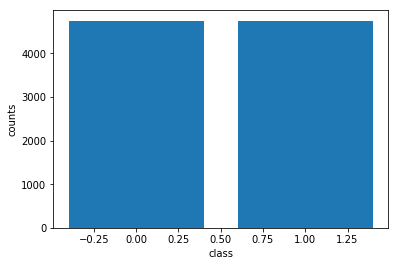

In [3]:
# number of samples per class
print(Counter(df_for_ml.label))
y = Counter(df_for_ml.label).values()
x = Counter(df_for_ml.label).keys()

plt.bar(x, y)
plt.xlabel("class")
plt.ylabel("counts")

We don't need to train-test split since we have already done that in the preprocessing stage. We will use 3-fold cross-validation for hyperparameter optimization. We drop the `label` and save as `X_train` or model inputs. We select the `label` and save as `y_train` or model outputs. 

In [4]:
X_train = df_for_ml.drop("label", axis=1)
y_train = df_for_ml["label"]

In [5]:
X_train.head()

,Accuracy_amin,Accuracy_amax,Accuracy_ptp,Accuracy_mean,Accuracy_std,Accuracy_skew,Accuracy_kurtosis,Accuracy_dominant_f,Accuracy_max_power,Bearing_amin,...,Speed_amin,Speed_amax,Speed_ptp,Speed_mean,Speed_std,Speed_skew,Speed_kurtosis,Speed_dominant_f,Speed_max_power,trip_len
0,3.0,2799.999,2796.999,12.430374,140.401703,18.562501,355.976100,0.003699,159.888103,0.0,...,-1.0,24.652620,25.652620,7.993038,7.579556,0.449920,-1.166522,0.002466,12.775905,811.0
1,3.0,2359.000,2356.000,10.506959,105.503375,19.617829,397.381173,0.000823,79.112140,0.0,...,-1.0,27.361435,28.361435,9.294027,8.152475,0.332334,-1.187257,0.000823,17.622542,1215.0
2,3.0,297.696,294.696,4.000672,10.866014,26.812184,722.152253,0.009485,0.660362,0.0,...,-1.0,19.800112,20.800112,5.013429,6.640247,1.116978,-0.237096,0.001355,14.784300,738.0
3,3.0,36.005,33.005,5.567349,4.479314,2.772290,7.895699,0.002415,4.160188,0.0,...,-1.0,6.097753,7.097753,1.066279,1.986364,1.281251,0.187867,0.002415,1.747948,828.0
4,3.0,41.329,38.329,10.444798,6.997645,1.348674,3.407665,0.004292,28.638661,0.0,...,-1.0,25.856476,26.856476,5.902065,6.158390,0.811600,-0.148722,0.004292,17.251487,233.0


In [6]:
y_train[:5]

0    0
1    0
2    1
3    1
4    0
Name: label, dtype: int64

The data was scaled using min-max scaling (0 - 1) as well as standard scaling. The scaler was fit on the training set and will be used to scale the test set, so it was saved as `{scaler}.sav`.

In [7]:
# Scaling
mmsc = MinMaxScaler()
stdsc = StandardScaler()

# scale the training set minmax/standard
scaler = "std"

if scaler == "std":
    sc = stdsc.fit(X_train)
elif scaler == "minmax":
    sc = mmsc.fit(X_train)

# save scaler
scalerfile = f'scalers/{scaler}.sav'
pickle.dump(sc, open(scalerfile, 'wb'))

feature_cols = X_train.columns

X_train = sc.transform(X_train)
X_train = pd.DataFrame(X_train, columns=feature_cols)

X_train.head()

,Accuracy_amin,Accuracy_amax,Accuracy_ptp,Accuracy_mean,Accuracy_std,Accuracy_skew,Accuracy_kurtosis,Accuracy_dominant_f,Accuracy_max_power,Bearing_amin,...,Speed_amin,Speed_amax,Speed_ptp,Speed_mean,Speed_std,Speed_skew,Speed_kurtosis,Speed_dominant_f,Speed_max_power,trip_len
0,-0.071368,6.674660,6.686775,0.041043,1.969006,2.457351,1.702288,-0.149145,-0.038564,-0.246424,...,-0.491433,0.644928,0.749728,-0.044373,0.659186,0.160306,-0.170696,-0.092533,-0.334700,-0.121452
1,-0.071368,5.571358,5.581909,-0.006762,1.424725,2.637656,1.939810,-0.193141,-0.040616,-0.246424,...,-0.491433,1.123842,1.219179,0.269778,0.953588,-0.012178,-0.177490,-0.163801,-0.070865,0.740632
2,-0.071368,0.414337,0.417577,-0.168470,-0.051256,3.866831,3.802879,-0.060637,-0.042610,-0.246424,...,-0.491433,-0.212988,-0.091236,-0.763863,0.176511,1.138799,0.133821,-0.140727,-0.225369,-0.277224
3,-0.071368,-0.240367,-0.238056,-0.129532,-0.150865,-0.240449,-0.294496,-0.168781,-0.042521,-0.246424,...,-0.491433,-2.635545,-2.465923,-1.716987,-2.214941,1.379768,0.273056,-0.094729,-0.935027,-0.085176
4,-0.071368,-0.227048,-0.224717,-0.008307,-0.111588,-0.483678,-0.320242,-0.140078,-0.041899,-0.246424,...,-0.491433,0.857768,0.958362,-0.549283,-0.071097,0.690847,0.162776,-0.013339,-0.091064,-1.354829


As a quick check of possible clusters, we calculate the principal components and plot the top 3 principal components in a 3D scatter plot. If there are clusters that correspond to the class label, classification may be expected to be much easier. However, if there is none, classification may be more difficult.

In [8]:
# are there visible clusters if we perform and look at it in 3d?

pca = PCA(n_components=20)
principalComponents = pca.fit_transform(X_train)
principalDf = pd.DataFrame(data=principalComponents)

Using Min-Max scaling, the first 10 principal components explain 80% of the variation in the data. The first 3 principal components roughly explain 50% of the variation. While using standard scaling, the first 10 principal components only explain 50% of the variance.

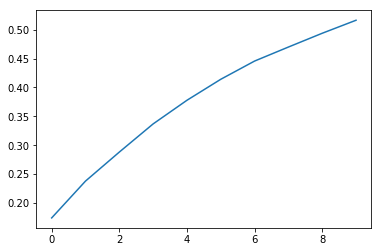

array([0.17427272, 0.23797266, 0.28819151, 0.33694648, 0.37784633,
       0.41417246, 0.445707  , 0.46995982, 0.4938163 , 0.51634019])

In [9]:
# explained variance ratio of first 10 principal components
# first 10 principal components explain 80% of the variance
plt.plot(np.cumsum(pca.explained_variance_ratio_[:10]))
plt.show()
np.cumsum(pca.explained_variance_ratio_[:10])

There's no clear, distinct clusters corresponding to the class labels. High classification may not be easily achievable.

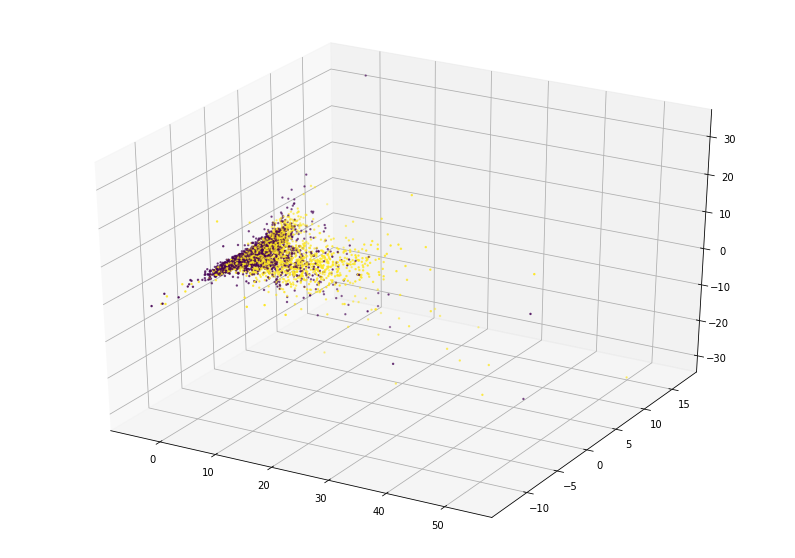

In [10]:
# plotting on the first 3 principal components
fig = plt.figure(figsize=(14, 10))
ax = plt.axes(projection='3d')

c = y_train
ax.scatter3D(principalDf.iloc[:, 0], principalDf.iloc[:, 1],
             principalDf.iloc[:, 2], c=c, cmap='viridis', s=2)

## Accuracy to Beat - PCC

The proportional chance criterion measures the chance that the sample will be correctly classified. This is a good baseline accuracy to beat. Since we made the number of samples per class equal, we get 50% random chance.

In [11]:
# proportional chance criterion
state_counts = Counter(y_train)
df_state = pd.DataFrame.from_dict(state_counts, orient='index')
num = (df_state[0] / df_state[0].sum())**2
pcc = np.round(num.sum(), 2)
pcc

0.5

## Machine Learning Models

We ran machine learning models using all the features on the scaled dataset. We ran logistic regression, linear support vector machines with L1 or L2 normalization, nonlinear support vector machines, random forest, decistion tree, gradient boosting machines, and naive-bayes classifier.

Gridsearch was used on a hyperparameter space with 3-fold cross validation to find the optimal hyperparameters per model. The accuracy vs a parameter was plotted for each model.

In [12]:
models_results = {'model': [], 'valid_acc': [], 'params': []}

### Logistic Regression

In [13]:
param_grid = {'penalty': ['l1', 'l2'], 'C': [
    0.01, 0.1, 0.5, 0.75, 1., 10, 100]}

clf = LogisticRegression()

logreg = GridSearchCV(clf, param_grid=param_grid,
                      return_train_score=True, cv=3, n_jobs=n_jobs)
logreg.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=36,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.01, 0.1, 0.5, 0.75, 1.0, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

Best validation accuracy: 0.6286075416052244
Best parameters: {'C': 0.1, 'penalty': 'l1'}


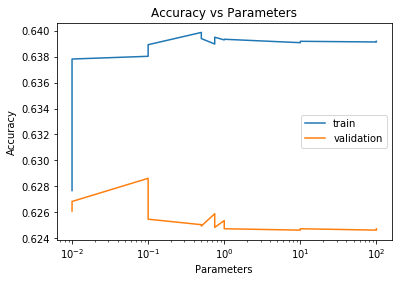

In [14]:
# calculate results
model_name = 'log_reg'
model = logreg
results = pd.DataFrame(model.cv_results_)
params = results.param_C
train_score = results.mean_train_score
valid_score = results.mean_test_score

# plot
plt.semilogx()
plt.plot(params, train_score, label="train")
plt.plot(params, valid_score, label="validation")
plt.xlabel("Parameters")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Parameters")
plt.legend()

# saving to dictionary of models and results
models_results["model"] += [model_name]
models_results["params"] += [model.best_params_]
models_results["valid_acc"] += [model.best_score_]

# print accuracies and parameters
print("Best validation accuracy:", model.best_score_)
print("Best parameters:", model.best_params_)

# save the model to disk
filename = f'models/{model_name}_{scaler}.sav'
pickle.dump(model, open(filename, 'wb'))

# save best_params
file = model.best_params_
filepath = f'results/{model_name}_{scaler}_best_params.sav'
pickle.dump(file, open(filepath, 'wb'))

# save feature importances
file = model.best_estimator_.coef_
filepath = f'results/{model_name}_{scaler}_feature_importances.sav'
pickle.dump(file, open(filepath, 'wb'))

### Linear SVC L1

In [15]:
param_grid = {'penalty': ['l1'], 'dual': [False],
              'C': [0.01, 0.1, 0.5, 0.75, 1., 10, 100, 1000]}
clf = LinearSVC()

lsvcl1 = GridSearchCV(clf, param_grid=param_grid,
                      return_train_score=True, cv=3, n_jobs=n_jobs)
lsvcl1.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params=None, iid='warn', n_jobs=36,
       param_grid={'penalty': ['l1'], 'dual': [False], 'C': [0.01, 0.1, 0.5, 0.75, 1.0, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

Best validation accuracy: 0.6295555087423635
Best parameters: {'C': 0.01, 'dual': False, 'penalty': 'l1'}


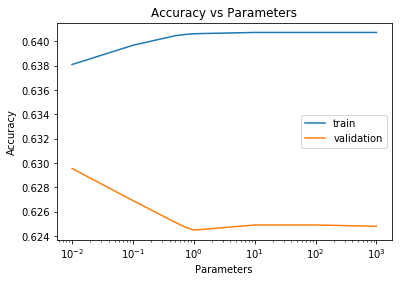

In [16]:
# calculate results
model_name = 'linear_svc_l1'
model = lsvcl1
results = pd.DataFrame(model.cv_results_)
params = results.param_C
train_score = results.mean_train_score
valid_score = results.mean_test_score

# plot
plt.semilogx()
plt.plot(params, train_score, label="train")
plt.plot(params, valid_score, label="validation")
plt.xlabel("Parameters")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Parameters")
plt.legend()

# saving to dictionary of models and results
models_results["model"] += [model_name]
models_results["params"] += [model.best_params_]
models_results["valid_acc"] += [model.best_score_]

# print accuracies and parameters
print("Best validation accuracy:", model.best_score_)
print("Best parameters:", model.best_params_)

# save the model to disk
filename = f'models/{model_name}_{scaler}.sav'
pickle.dump(model, open(filename, 'wb'))

# save best_params
file = model.best_params_
filepath = f'results/{model_name}_{scaler}_best_params.sav'
pickle.dump(file, open(filepath, 'wb'))

# save feature importances
file = model.best_estimator_.coef_
filepath = f'results/{model_name}_{scaler}_feature_importances.sav'
pickle.dump(file, open(filepath, 'wb'))

### Linear SVC L2

In [17]:
param_grid = {'penalty': ['l2'], 'loss': ['hinge'],
              'C': [0.01, 0.1, 0.5, 0.75, 1., 10, 100, 1000]}

clf = LinearSVC()

lsvcl2 = GridSearchCV(clf, param_grid=param_grid,
                      return_train_score=True, cv=3, n_jobs=n_jobs)
lsvcl2.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params=None, iid='warn', n_jobs=36,
       param_grid={'penalty': ['l2'], 'loss': ['hinge'], 'C': [0.01, 0.1, 0.5, 0.75, 1.0, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

Best validation accuracy: 0.63261006951759
Best parameters: {'C': 0.1, 'loss': 'hinge', 'penalty': 'l2'}


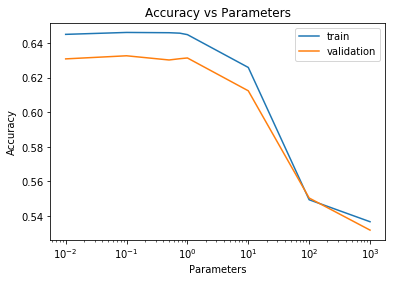

In [18]:
# calculate results
model_name = 'linear_svc_l2'
model = lsvcl2
results = pd.DataFrame(model.cv_results_)
params = results.param_C
train_score = results.mean_train_score
valid_score = results.mean_test_score

# plot
plt.semilogx()
plt.plot(params, train_score, label="train")
plt.plot(params, valid_score, label="validation")
plt.xlabel("Parameters")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Parameters")
plt.legend()

# saving to dictionary of models and results
models_results["model"] += [model_name]
models_results["params"] += [model.best_params_]
models_results["valid_acc"] += [model.best_score_]

# print accuracies and parameters
print("Best validation accuracy:", model.best_score_)
print("Best parameters:", model.best_params_)

# save the model to disk
filename = f'models/{model_name}_{scaler}.sav'
pickle.dump(model, open(filename, 'wb'))

# save best_params
file = model.best_params_
filepath = f'results/{model_name}_{scaler}_best_params.sav'
pickle.dump(file, open(filepath, 'wb'))

# save feature importances
file = model.best_estimator_.coef_
filepath = f'results/{model_name}_{scaler}_feature_importances.sav'
pickle.dump(file, open(filepath, 'wb'))

### Nonlinear SVC

In [19]:
param_grid = {'C': [0.1, 0.5, 0.75, 1., 10, 100, 1000, 2000]}

clf = SVC()

svc = GridSearchCV(clf, param_grid=param_grid,
                   return_train_score=True, cv=3, n_jobs=n_jobs)
svc.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=36,
       param_grid={'C': [0.1, 0.5, 0.75, 1.0, 10, 100, 1000, 2000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

Best validation accuracy: 0.6351379818832947
Best parameters: {'C': 0.75}


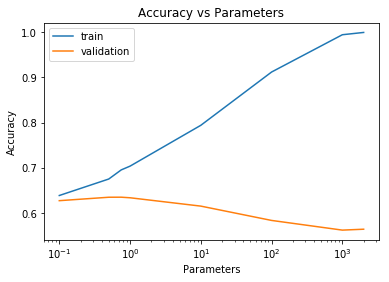

In [20]:
# calculate results
model_name = 'svc'
model = svc
results = pd.DataFrame(model.cv_results_)
params = results.param_C
train_score = results.mean_train_score
valid_score = results.mean_test_score

# plot
plt.semilogx()
plt.plot(params, train_score, label="train")
plt.plot(params, valid_score, label="validation")
plt.xlabel("Parameters")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Parameters")
plt.legend()

# saving to dictionary of models and results
models_results["model"] += [model_name]
models_results["params"] += [model.best_params_]
models_results["valid_acc"] += [model.best_score_]

# print accuracies and parameters
print("Best validation accuracy:", model.best_score_)
print("Best parameters:", model.best_params_)

# save the model to disk
filename = f'models/{model_name}_{scaler}.sav'
pickle.dump(model, open(filename, 'wb'))

# save best_params
file = model.best_params_
filepath = f'results/{model_name}_{scaler}_best_params.sav'
pickle.dump(file, open(filepath, 'wb'))

### GBM

In [21]:
param_grid = {'learning_rate': [0.01, 0.05, 0.1],
              "n_estimators": [500], "max_depth": [2, 3, 4, 5]}

clf = GradientBoostingClassifier()

gbm = GridSearchCV(clf, param_grid=param_grid,
                   return_train_score=True, cv=3, n_jobs=n_jobs)
gbm.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=36,
       param_grid={'learning_rate': [0.01, 0.05, 0.1], 'n_estimators': [500], 'max_depth': [2, 3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

Best validation accuracy: 0.6339793553823467
Best parameters: {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 500}


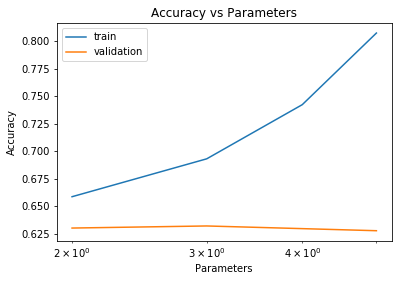

In [22]:
# calculate results
model_name = 'gbm'
model = gbm
results = pd.DataFrame(model.cv_results_)
params = results[results.param_learning_rate == 0.01].param_max_depth
train_score = results[results.param_learning_rate == 0.01].mean_train_score
valid_score = results[results.param_learning_rate == 0.01].mean_test_score

# plot
plt.semilogx()
plt.plot(params, train_score, label="train")
plt.plot(params, valid_score, label="validation")
plt.xlabel("Parameters")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Parameters")
plt.legend()

# saving to dictionary of models and results
models_results["model"] += [model_name]
models_results["params"] += [model.best_params_]
models_results["valid_acc"] += [model.best_score_]

# print accuracies and parameters
print("Best validation accuracy:", model.best_score_)
print("Best parameters:", model.best_params_)

# save the model to disk
filename = f'models/{model_name}_{scaler}.sav'
pickle.dump(model, open(filename, 'wb'))

# save best_params
file = model.best_params_
filepath = f'results/{model_name}_{scaler}_best_params.sav'
pickle.dump(file, open(filepath, 'wb'))

# save feature importances
file = model.best_estimator_.feature_importances_
filepath = f'results/{model_name}_{scaler}_feature_importances.sav'
pickle.dump(file, open(filepath, 'wb'))

### Random Forest

In [23]:
param_grid = {'min_samples_split': [2, 3, 4], "max_depth": [2, 3, 4, 5]}

clf = RandomForestClassifier()

rf = GridSearchCV(clf, param_grid=param_grid,
                  return_train_score=True, cv=3, n_jobs=n_jobs)
rf.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=36,
       param_grid={'min_samples_split': [2, 3, 4], 'max_depth': [2, 3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

Best validation accuracy: 0.6280808931957026
Best parameters: {'max_depth': 5, 'min_samples_split': 4}


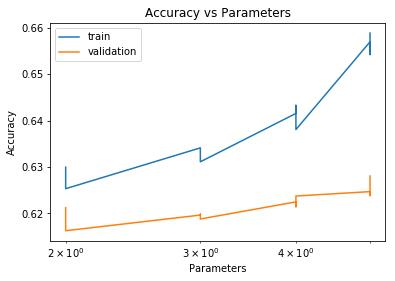

In [24]:
# calculate results
model_name = 'rf'
model = rf
results = pd.DataFrame(model.cv_results_)
params = results.param_max_depth
train_score = results.mean_train_score
valid_score = results.mean_test_score

# plot
plt.semilogx()
plt.plot(params, train_score, label="train")
plt.plot(params, valid_score, label="validation")
plt.xlabel("Parameters")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Parameters")
plt.legend()

# saving to dictionary of models and results
models_results["model"] += [model_name]
models_results["params"] += [model.best_params_]
models_results["valid_acc"] += [model.best_score_]

# print accuracies and parameters
print("Best validation accuracy:", model.best_score_)
print("Best parameters:", model.best_params_)

# save the model to disk
filename = f'models/{model_name}_{scaler}.sav'
pickle.dump(model, open(filename, 'wb'))

# save best_params
file = model.best_params_
filepath = f'results/{model_name}_{scaler}_best_params.sav'
pickle.dump(file, open(filepath, 'wb'))

# save feature importances
file = model.best_estimator_.feature_importances_
filepath = f'results/{model_name}_{scaler}_feature_importances.sav'
pickle.dump(file, open(filepath, 'wb'))

### Decision Tree

In [25]:
param_grid = {'min_samples_split': [2, 3, 4], "max_depth": [2, 3, 4, 5]}

clf = DecisionTreeClassifier()

dt = GridSearchCV(clf, param_grid=param_grid,
                  return_train_score=True, cv=3, n_jobs=n_jobs)
dt.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=36,
       param_grid={'min_samples_split': [2, 3, 4], 'max_depth': [2, 3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

Best validation accuracy: 0.616810617231936
Best parameters: {'max_depth': 2, 'min_samples_split': 2}


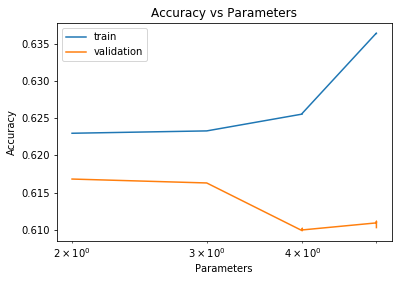

In [26]:
# calculate results
model_name = 'dt'
model = dt
results = pd.DataFrame(model.cv_results_)
params = results.param_max_depth
train_score = results.mean_train_score
valid_score = results.mean_test_score

# plot
plt.semilogx()
plt.plot(params, train_score, label="train")
plt.plot(params, valid_score, label="validation")
plt.xlabel("Parameters")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Parameters")
plt.legend()

# saving to dictionary of models and results
models_results["model"] += [model_name]
models_results["params"] += [model.best_params_]
models_results["valid_acc"] += [model.best_score_]

# print accuracies and parameters
print("Best validation accuracy:", model.best_score_)
print("Best parameters:", model.best_params_)

# save the model to disk
filename = f'models/{model_name}_{scaler}.sav'
pickle.dump(model, open(filename, 'wb'))

# save best_params
file = model.best_params_
filepath = f'results/{model_name}_{scaler}_best_params.sav'
pickle.dump(file, open(filepath, 'wb'))

# save feature importances
file = model.best_estimator_.feature_importances_
filepath = f'results/{model_name}_{scaler}_feature_importances.sav'
pickle.dump(file, open(filepath, 'wb'))

### Naive Bayes

In [27]:
param_grid = {'var_smoothing': [1e-9, 1e-5, 1e-1]}
clf = GaussianNB()

nb = GridSearchCV(clf, param_grid=param_grid,
                  return_train_score=True, cv=3, n_jobs=n_jobs)
nb.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=GaussianNB(priors=None, var_smoothing=1e-09),
       fit_params=None, iid='warn', n_jobs=36,
       param_grid={'var_smoothing': [1e-09, 1e-05, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

Best validation accuracy: 0.5543501158626502
Best parameters: {'var_smoothing': 1e-09}


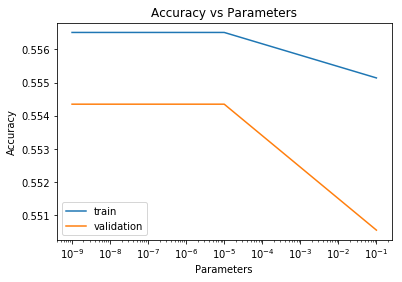

In [28]:
# calculate results
model_name = 'nb'
model = nb
results = pd.DataFrame(model.cv_results_)
params = results.param_var_smoothing
train_score = results.mean_train_score
valid_score = results.mean_test_score

# plot
plt.semilogx()
plt.plot(params, train_score, label="train")
plt.plot(params, valid_score, label="validation")
plt.xlabel("Parameters")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Parameters")
plt.legend()

# saving to dictionary of models and results
models_results["model"] += [model_name]
models_results["params"] += [model.best_params_]
models_results["valid_acc"] += [model.best_score_]

# print accuracies and parameters
print("Best validation accuracy:", model.best_score_)
print("Best parameters:", model.best_params_)

# save the model to disk
filename = f'models/{model_name}_{scaler}.sav'
pickle.dump(model, open(filename, 'wb'))

# save best_params
file = model.best_params_
filepath = f'results/{model_name}_{scaler}_best_params.sav'
pickle.dump(file, open(filepath, 'wb'))

### Results

In [29]:
results = pd.DataFrame(models_results).sort_values(
    by="valid_acc", ascending=False)
results.drop_duplicates(subset="valid_acc", inplace=True)

In [30]:
# save to csv
results.to_csv(f"results/ml_results_{scaler}_pcc-{pcc}_.csv", index=False)

Using standard scaler, GBM tops the classification performance followed by Linear SVC with L1 norm and logistic regression. All models beat the PCC of 50%, with GBM getting 63% accuracy.

In [31]:
# results from standard scaler
pd.set_option('display.max_colwidth', -1)
pd.read_csv("results/ml_results_std_pcc-0.5_.csv").drop_duplicates(subset="model")

,model,valid_acc,params
0,svc,0.635138,{'C': 0.75}
1,gbm,0.633979,"{'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 500}"
2,linear_svc_l2,0.632610,"{'C': 0.1, 'loss': 'hinge', 'penalty': 'l2'}"
3,linear_svc_l1,0.629556,"{'C': 0.01, 'dual': False, 'penalty': 'l1'}"
4,log_reg,0.628608,"{'C': 0.1, 'penalty': 'l1'}"
5,rf,0.628081,"{'max_depth': 5, 'min_samples_split': 4}"
6,dt,0.616811,"{'max_depth': 2, 'min_samples_split': 2}"
7,nb,0.554350,{'var_smoothing': 1e-09}


Using min-max scaling, the best performing model was SVC with 63.6% accuracy followed by GBM with 63.4% accuracy. All models beat the PCC.

In [32]:
# results from minmax scaler
pd.set_option('display.max_colwidth', -1)
pd.read_csv(
    "results/ml_results_minmax_pcc-0.5_.csv").drop_duplicates(subset="model")

,model,valid_acc,params
0,svc,0.636402,{'C': 1000}
1,gbm,0.633663,"{'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 500}"
2,linear_svc_l2,0.630925,"{'C': 1.0, 'loss': 'hinge', 'penalty': 'l2'}"
3,linear_svc_l1,0.629029,"{'C': 0.75, 'dual': False, 'penalty': 'l1'}"
4,log_reg,0.628608,"{'C': 1.0, 'penalty': 'l1'}"
5,rf,0.627554,"{'max_depth': 5, 'min_samples_split': 4}"
6,dt,0.616811,"{'max_depth': 2, 'min_samples_split': 2}"
7,nb,0.554666,{'var_smoothing': 1e-05}


### Most Predictive Features According to the Best ML Model

Below shows that the most predictive features are trip length, bearing standard deviation, speed mean, z-axis acceleration standard deviation, speed skewness, and speed range.

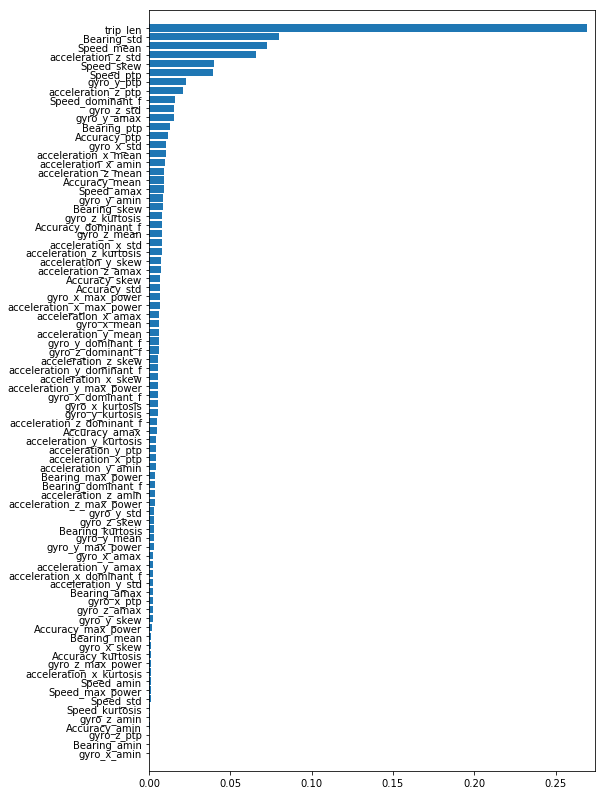

In [33]:
# GBM can be used for feature importances
filepath = f'results/gbm_{scaler}_feature_importances.sav'
feature_importances = pickle.load(open(filepath, 'rb')).flatten()

plt.figure(figsize=(8, 14))
y = feature_importances
inds = np.argsort(y)
y = y[inds]
x = feature_cols[inds]
plt.barh(x, y)
plt.margins(0.02)

## Using Only Top 30 features

We wanted to find out what will be the result on the SVCs and GBM using only the top 30 features.

In [34]:
models_results_b = {"features": [], "model": [], "params": [], "valid_acc": []}

In [35]:
# feats from most important down
top_feats = list(x[::-1][:30])
top_feats

['trip_len',
 'Bearing_std',
 'Speed_mean',
 'acceleration_z_std',
 'Speed_skew',
 'Speed_ptp',
 'gyro_y_ptp',
 'acceleration_z_ptp',
 'Speed_dominant_f',
 'gyro_z_std',
 'gyro_y_amax',
 'Bearing_ptp',
 'Accuracy_ptp',
 'gyro_x_std',
 'acceleration_x_mean',
 'acceleration_x_amin',
 'acceleration_z_mean',
 'Accuracy_mean',
 'Speed_amax',
 'gyro_y_amin',
 'Bearing_skew',
 'gyro_z_kurtosis',
 'Accuracy_dominant_f',
 'gyro_z_mean',
 'acceleration_x_std',
 'acceleration_z_kurtosis',
 'acceleration_y_skew',
 'acceleration_z_amax',
 'Accuracy_skew',
 'Accuracy_std']

In [36]:
X_train_b = X_train[top_feats]
X_train_b.shape

(9494, 30)

### Linear SVC L1

In [37]:
param_path = f"results/linear_svc_l1_{scaler}_best_params.sav"
best_params = pickle.load(open(param_path, 'rb'))
param_grid = {k: [v] for k, v in best_params.items()}

clf = LinearSVC()
lsvcl1 = GridSearchCV(clf, param_grid=param_grid,
                      return_train_score=True, cv=3, n_jobs=n_jobs)

model = lsvcl1
model_name = 'linear_svc_l1_b'

model.fit(X_train_b, y_train)

# calculate results
results = pd.DataFrame(model.cv_results_)
valid_score = results.mean_test_score.values[0]

# saving to dictionary of models and results
models_results_b["features"] += [top_feats]
models_results_b["model"] += [model_name]
models_results_b["params"] += [model.best_params_]
models_results_b["valid_acc"] += [model.best_score_]

model.fit(X_train_b, y_train)

# save the model to disk
filename = f'models/{model_name}_{scaler}.sav'
pickle.dump(model, open(filename, 'wb'))

# print accuracies and parameters
print("Best validation accuracy:", model.best_score_)
print("Best parameters:", model.best_params_)

Best validation accuracy: 0.6248156730566674
Best parameters: {'C': 0.01, 'dual': False, 'penalty': 'l1'}


### Linear SVC L2

In [38]:
param_path = f"results/linear_svc_l2_{scaler}_best_params.sav"
best_params = pickle.load(open(param_path, 'rb'))
param_grid = {k: [v] for k, v in best_params.items()}

clf = LinearSVC()
lsvcl2 = GridSearchCV(clf, param_grid=param_grid,
                      return_train_score=True, cv=3, n_jobs=n_jobs)

model = lsvcl2
model_name = 'linear_svc_l2_b'

model.fit(X_train_b, y_train)

# calculate results
results = pd.DataFrame(model.cv_results_)
valid_score = results.mean_test_score.values[0]

# saving to dictionary of models and results
models_results_b["features"] += [top_feats]
models_results_b["model"] += [model_name]
models_results_b["params"] += [model.best_params_]
models_results_b["valid_acc"] += [model.best_score_]

model.fit(X_train_b, y_train)

# save the model to disk
filename = f'models/{model_name}_{scaler}.sav'
pickle.dump(model, open(filename, 'wb'))

# print accuracies and parameters
print("Best validation accuracy:", model.best_score_)
print("Best parameters:", model.best_params_)

Best validation accuracy: 0.6301874868337898
Best parameters: {'C': 0.1, 'loss': 'hinge', 'penalty': 'l2'}


### Nonlinear SVC

In [39]:
param_path = f"results/svc_{scaler}_best_params.sav"
best_params = pickle.load(open(param_path, 'rb'))
param_grid = {k: [v] for k, v in best_params.items()}

clf = SVC()
svc = GridSearchCV(clf, param_grid=param_grid,
                   return_train_score=True, cv=3, n_jobs=n_jobs)

model = svc
model_name = 'svc_b'

model.fit(X_train_b, y_train)

# calculate results
results = pd.DataFrame(model.cv_results_)
valid_score = results.mean_test_score.values[0]

# saving to dictionary of models and results
models_results_b["features"] += [top_feats]
models_results_b["model"] += [model_name]
models_results_b["params"] += [model.best_params_]
models_results_b["valid_acc"] += [model.best_score_]

model.fit(X_train_b, y_train)

# save the model to disk
filename = f'models/{model_name}_{scaler}.sav'
pickle.dump(model, open(filename, 'wb'))

# print accuracies and parameters
print("Best validation accuracy:", model.best_score_)
print("Best parameters:", model.best_params_)

Best validation accuracy: 0.6340846850642512
Best parameters: {'C': 0.75}


### GBM

In [40]:
param_path = f"results/gbm_{scaler}_best_params.sav"
best_params = pickle.load(open(param_path, 'rb'))
param_grid = {k: [v] for k, v in best_params.items()}

clf = GradientBoostingClassifier()
gbm_b = GridSearchCV(clf, param_grid=param_grid,
                     return_train_score=True, cv=3, n_jobs=n_jobs)


model = gbm_b
model_name = 'gbm_b'

model.fit(X_train_b, y_train)

# calculate results
results = pd.DataFrame(model.cv_results_)
valid_score = results.mean_test_score.values[0]

# saving to dictionary of models and results
models_results_b["features"] += [top_feats]
models_results_b["model"] += [model_name]
models_results_b["params"] += [model.best_params_]
models_results_b["valid_acc"] += [model.best_score_]

model.fit(X_train_b, y_train)

# save the model to disk
filename = f'models/{model_name}_{scaler}.sav'
pickle.dump(model, open(filename, 'wb'))

# print accuracies and parameters
print("Best validation accuracy:", model.best_score_)
print("Best parameters:", model.best_params_)

Best validation accuracy: 0.6358752896566252
Best parameters: {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 500}


### Results

Using only the top 30 features, GBM topped the models with 63.6% accuracy followed by SVC with 63.5% accuracy. Despite cutting the number of features from 82 to 30, GBM performance improved while SVC's performance only very slightly declined.

In [73]:
results = pd.DataFrame(models_results_b).sort_values(
    by="valid_acc", ascending=False)
results.drop_duplicates(subset="valid_acc", inplace=True)

In [42]:
# save to csv
results.to_csv(f"results/ml_results_b_{scaler}.csv", index=False)

In [74]:
pd.read_csv("results/ml_results_b_minmax.csv")

,features,model,params,valid_acc
0,"['trip_len', 'Bearing_std', 'Speed_mean', 'acceleration_z_std', 'Speed_skew', 'Speed_ptp', 'gyro_y_ptp', 'acceleration_z_ptp', 'Speed_dominant_f', 'gyro_z_std', 'gyro_y_amax', 'Bearing_ptp', 'Accuracy_ptp', 'gyro_x_std', 'acceleration_x_mean', 'acceleration_x_amin', 'acceleration_z_mean', 'Speed_amax', 'acceleration_z_kurtosis', 'gyro_y_amin', 'Bearing_skew', 'gyro_z_kurtosis', 'Accuracy_dominant_f', 'acceleration_y_skew', 'Accuracy_mean', 'acceleration_x_std', 'acceleration_z_amax', 'gyro_z_mean', 'acceleration_x_max_power', 'Accuracy_skew']",gbm_b,"{'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 500}",0.635665
1,"['trip_len', 'Bearing_std', 'Speed_mean', 'acceleration_z_std', 'Speed_skew', 'Speed_ptp', 'gyro_y_ptp', 'acceleration_z_ptp', 'Speed_dominant_f', 'gyro_z_std', 'gyro_y_amax', 'Bearing_ptp', 'Accuracy_ptp', 'gyro_x_std', 'acceleration_x_mean', 'acceleration_x_amin', 'acceleration_z_mean', 'Speed_amax', 'acceleration_z_kurtosis', 'gyro_y_amin', 'Bearing_skew', 'gyro_z_kurtosis', 'Accuracy_dominant_f', 'acceleration_y_skew', 'Accuracy_mean', 'acceleration_x_std', 'acceleration_z_amax', 'gyro_z_mean', 'acceleration_x_max_power', 'Accuracy_skew']",svc_b,{'C': 1000},0.635454
2,"['trip_len', 'Bearing_std', 'Speed_mean', 'acceleration_z_std', 'Speed_skew', 'Speed_ptp', 'gyro_y_ptp', 'acceleration_z_ptp', 'Speed_dominant_f', 'gyro_z_std', 'gyro_y_amax', 'Bearing_ptp', 'Accuracy_ptp', 'gyro_x_std', 'acceleration_x_mean', 'acceleration_x_amin', 'acceleration_z_mean', 'Speed_amax', 'acceleration_z_kurtosis', 'gyro_y_amin', 'Bearing_skew', 'gyro_z_kurtosis', 'Accuracy_dominant_f', 'acceleration_y_skew', 'Accuracy_mean', 'acceleration_x_std', 'acceleration_z_amax', 'gyro_z_mean', 'acceleration_x_max_power', 'Accuracy_skew']",linear_svc_l2_b,"{'C': 1.0, 'loss': 'hinge', 'penalty': 'l2'}",0.628292
3,"['trip_len', 'Bearing_std', 'Speed_mean', 'acceleration_z_std', 'Speed_skew', 'Speed_ptp', 'gyro_y_ptp', 'acceleration_z_ptp', 'Speed_dominant_f', 'gyro_z_std', 'gyro_y_amax', 'Bearing_ptp', 'Accuracy_ptp', 'gyro_x_std', 'acceleration_x_mean', 'acceleration_x_amin', 'acceleration_z_mean', 'Speed_amax', 'acceleration_z_kurtosis', 'gyro_y_amin', 'Bearing_skew', 'gyro_z_kurtosis', 'Accuracy_dominant_f', 'acceleration_y_skew', 'Accuracy_mean', 'acceleration_x_std', 'acceleration_z_amax', 'gyro_z_mean', 'acceleration_x_max_power', 'Accuracy_skew']",linear_svc_l1_b,"{'C': 0.75, 'dual': False, 'penalty': 'l1'}",0.624184


In [75]:
pd.read_csv("results/ml_results_b_std.csv")

,features,model,params,valid_acc
0,"['trip_len', 'Bearing_std', 'Speed_mean', 'acceleration_z_std', 'Speed_skew', 'Speed_ptp', 'gyro_y_ptp', 'acceleration_z_ptp', 'Speed_dominant_f', 'gyro_z_std', 'gyro_y_amax', 'Bearing_ptp', 'Accuracy_ptp', 'gyro_x_std', 'acceleration_x_mean', 'acceleration_x_amin', 'acceleration_z_mean', 'Accuracy_mean', 'Speed_amax', 'gyro_y_amin', 'Bearing_skew', 'gyro_z_kurtosis', 'Accuracy_dominant_f', 'gyro_z_mean', 'acceleration_x_std', 'acceleration_z_kurtosis', 'acceleration_y_skew', 'acceleration_z_amax', 'Accuracy_skew', 'Accuracy_std']",gbm_b,"{'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 500}",0.635770
1,"['trip_len', 'Bearing_std', 'Speed_mean', 'acceleration_z_std', 'Speed_skew', 'Speed_ptp', 'gyro_y_ptp', 'acceleration_z_ptp', 'Speed_dominant_f', 'gyro_z_std', 'gyro_y_amax', 'Bearing_ptp', 'Accuracy_ptp', 'gyro_x_std', 'acceleration_x_mean', 'acceleration_x_amin', 'acceleration_z_mean', 'Accuracy_mean', 'Speed_amax', 'gyro_y_amin', 'Bearing_skew', 'gyro_z_kurtosis', 'Accuracy_dominant_f', 'gyro_z_mean', 'acceleration_x_std', 'acceleration_z_kurtosis', 'acceleration_y_skew', 'acceleration_z_amax', 'Accuracy_skew', 'Accuracy_std']",svc_b,{'C': 0.75},0.634085
2,"['trip_len', 'Bearing_std', 'Speed_mean', 'acceleration_z_std', 'Speed_skew', 'Speed_ptp', 'gyro_y_ptp', 'acceleration_z_ptp', 'Speed_dominant_f', 'gyro_z_std', 'gyro_y_amax', 'Bearing_ptp', 'Accuracy_ptp', 'gyro_x_std', 'acceleration_x_mean', 'acceleration_x_amin', 'acceleration_z_mean', 'Accuracy_mean', 'Speed_amax', 'gyro_y_amin', 'Bearing_skew', 'gyro_z_kurtosis', 'Accuracy_dominant_f', 'gyro_z_mean', 'acceleration_x_std', 'acceleration_z_kurtosis', 'acceleration_y_skew', 'acceleration_z_amax', 'Accuracy_skew', 'Accuracy_std']",linear_svc_l2_b,"{'C': 0.1, 'loss': 'hinge', 'penalty': 'l2'}",0.630187
3,"['trip_len', 'Bearing_std', 'Speed_mean', 'acceleration_z_std', 'Speed_skew', 'Speed_ptp', 'gyro_y_ptp', 'acceleration_z_ptp', 'Speed_dominant_f', 'gyro_z_std', 'gyro_y_amax', 'Bearing_ptp', 'Accuracy_ptp', 'gyro_x_std', 'acceleration_x_mean', 'acceleration_x_amin', 'acceleration_z_mean', 'Accuracy_mean', 'Speed_amax', 'gyro_y_amin', 'Bearing_skew', 'gyro_z_kurtosis', 'Accuracy_dominant_f', 'gyro_z_mean', 'acceleration_x_std', 'acceleration_z_kurtosis', 'acceleration_y_skew', 'acceleration_z_amax', 'Accuracy_skew', 'Accuracy_std']",linear_svc_l1_b,"{'C': 0.01, 'dual': False, 'penalty': 'l1'}",0.624816


## Incremental Adding of Features from Most Predictive

Our next experiment involves incrementally adding features that improve the accuracy starting from the most predictive feature to the least predictive feature. If a feature reduces accuracy, it will not be added and the next feature will be evaluated.

In [43]:
models_results_c = {"features": [], "model": [], "params": [], "valid_acc": []}
# feats from most important down
top_feats = list(x[::-1])

### Nonlinear SVC

In [44]:
param_path = f"results/svc_{scaler}_best_params.sav"
best_params = pickle.load(open(param_path, 'rb'))
param_grid = {k: [v] for k, v in best_params.items()}

clf = SVC()
svc_c = GridSearchCV(clf, param_grid=param_grid,
                     return_train_score=True, cv=3, n_jobs=n_jobs)

valid_accs = []
feats_c = []
best_score = 0

model = svc_c
model_name = 'svc_c'

# checking features one by one
for i in range(len(top_feats)):
    feats_c += [top_feats[i]]
    X_train_c = X_train[feats_c]

    model.fit(X_train_c, y_train)

    # calculate results
    results = pd.DataFrame(model.cv_results_)
    valid_score = results.mean_test_score.values[0]

    if valid_score > best_score:
        best_score = valid_score
        valid_accs.append(valid_score)

        # print accuracies and parameters
        print("Best validation accuracy:", best_score)

    else:
        feats_c = feats_c[:-1]

models_results_c["features"] += [feats_c]
models_results_c["model"] += [model_name]
models_results_c["params"] += [model.best_params_]
models_results_c["valid_acc"] += [best_score]

X_train_c = X_train[feats_c]
model.fit(X_train_c, y_train)
print(feats_c)

# save the model to disk
filename = f'models/{model_name}_{scaler}.sav'
pickle.dump(model, open(filename, 'wb'))

Best validation accuracy: 0.6028017695386559
Best validation accuracy: 0.6064883084053087
Best validation accuracy: 0.6190225405519275
Best validation accuracy: 0.6254476511480935
Best validation accuracy: 0.6278702338318938
Best validation accuracy: 0.633452706972825
Best validation accuracy: 0.6351379818832947
Best validation accuracy: 0.6367179271118601
Best validation accuracy: 0.6368232567937645
Best validation accuracy: 0.637560564567095
Best validation accuracy: 0.6384032020223299
Best validation accuracy: 0.6392458394775647
Best validation accuracy: 0.6396671582051823
Best validation accuracy: 0.6409311143880345
Best validation accuracy: 0.6412471034337476
Best validation accuracy: 0.6415630924794608
Best validation accuracy: 0.6420897408889825
Best validation accuracy: 0.6435643564356436
['trip_len', 'Bearing_std', 'Speed_mean', 'acceleration_z_std', 'Speed_skew', 'Speed_ptp', 'gyro_y_ptp', 'acceleration_z_ptp', 'Speed_dominant_f', 'gyro_z_std', 'gyro_y_amax', 'Bearing_ptp', '

### Linear SVC L1

In [45]:
param_path = f"results/linear_svc_l1_{scaler}_best_params.sav"
best_params = pickle.load(open(param_path, 'rb'))
param_grid = {k: [v] for k, v in best_params.items()}

clf = LinearSVC()
lsvcl1_c = GridSearchCV(clf, param_grid=param_grid,
                        return_train_score=True, cv=3, n_jobs=n_jobs)

valid_accs = []
feats_c = []
best_score = 0

model = lsvcl1_c
model_name = 'linear_svc_l1_c'

# checking features one by one
for i in range(len(top_feats)):
    feats_c += [top_feats[i]]
    X_train_c = X_train[feats_c]

    model.fit(X_train_c, y_train)

    # calculate results
    results = pd.DataFrame(model.cv_results_)
    valid_score = results.mean_test_score.values[0]

    if valid_score > best_score:
        best_score = valid_score
        valid_accs.append(valid_score)

        # print accuracies and parameters
        print("Best validation accuracy:", best_score)

    else:
        feats_c = feats_c[:-1]

models_results_c["features"] += [feats_c]
models_results_c["model"] += [model_name]
models_results_c["params"] += [model.best_params_]
models_results_c["valid_acc"] += [best_score]

X_train_c = X_train[feats_c]
model.fit(X_train_c, y_train)
print(feats_c)

# save the model to disk
filename = f'models/{model_name}_{scaler}.sav'
pickle.dump(model, open(filename, 'wb'))

Best validation accuracy: 0.5996418790815252
Best validation accuracy: 0.601327153991995
Best validation accuracy: 0.6075416052243522
Best validation accuracy: 0.6201811670528755
Best validation accuracy: 0.6213397935538235
Best validation accuracy: 0.6214451232357279
Best validation accuracy: 0.6221824310090583
Best validation accuracy: 0.622393090372867
Best validation accuracy: 0.6231303981461976
Best validation accuracy: 0.623551716873815
Best validation accuracy: 0.6241836949652413
Best validation accuracy: 0.6242890246471455
Best validation accuracy: 0.6243943543290499
Best validation accuracy: 0.6246050136928587
Best validation accuracy: 0.6262902886033285
Best validation accuracy: 0.6265009479671372
Best validation accuracy: 0.6275542447861807
Best validation accuracy: 0.6277649041499894
Best validation accuracy: 0.6279755635137982
Best validation accuracy: 0.6283968822414157
Best validation accuracy: 0.6292395196966505
Best validation accuracy: 0.6295555087423635
['trip_len', 

### Linear SVC L2

In [46]:
param_path = f"results/linear_svc_l2_{scaler}_best_params.sav"
best_params = pickle.load(open(param_path, 'rb'))
param_grid = {k: [v] for k, v in best_params.items()}

clf = LinearSVC()
lsvcl2_c = GridSearchCV(clf, param_grid=param_grid,
                        return_train_score=True, cv=3, n_jobs=n_jobs)

valid_accs = []
feats_c = []
best_score = 0

model = lsvcl2_c
model_name = 'linear_svc_l2_c'

# checking features one by one
for i in range(len(top_feats)):
    feats_c += [top_feats[i]]
    X_train_c = X_train[feats_c]

    model.fit(X_train_c, y_train)

    # calculate results
    results = pd.DataFrame(model.cv_results_)
    valid_score = results.mean_test_score.values[0]

    if valid_score > best_score:
        best_score = valid_score
        valid_accs.append(valid_score)

        # print accuracies and parameters
        print("Best validation accuracy:", best_score)

    else:
        feats_c = feats_c[:-1]

models_results_c["features"] += [feats_c]
models_results_c["model"] += [model_name]
models_results_c["params"] += [model.best_params_]
models_results_c["valid_acc"] += [best_score]

X_train_c = X_train[feats_c]
model.fit(X_train_c, y_train)
print(feats_c)

# save the model to disk
filename = f'models/{model_name}_{scaler}.sav'
pickle.dump(model, open(filename, 'wb'))

Best validation accuracy: 0.6026964398567516
Best validation accuracy: 0.6041710554034126
Best validation accuracy: 0.611544133136718
Best validation accuracy: 0.6208131451443016
Best validation accuracy: 0.6253423214661892
Best validation accuracy: 0.6275542447861807
Best validation accuracy: 0.6276595744680851
Best validation accuracy: 0.6280808931957026
Best validation accuracy: 0.6289235306509374
Best validation accuracy: 0.6294501790604592
Best validation accuracy: 0.629660838424268
Best validation accuracy: 0.6302928165156941
Best validation accuracy: 0.6312407836528333
Best validation accuracy: 0.6315567726985465
Best validation accuracy: 0.6321887507899726
Best validation accuracy: 0.6328207288813987
['trip_len', 'Bearing_std', 'Speed_mean', 'acceleration_z_std', 'Speed_skew', 'gyro_y_ptp', 'gyro_z_mean', 'gyro_z_dominant_f', 'acceleration_y_dominant_f', 'acceleration_x_skew', 'Accuracy_amax', 'acceleration_y_ptp', 'gyro_y_max_power', 'Speed_max_power', 'Speed_kurtosis', 'gyro_

### GBM

In [47]:
param_path = f"results/gbm_{scaler}_best_params.sav"
best_params = pickle.load(open(param_path, 'rb'))
param_grid = {k: [v] for k, v in best_params.items()}

clf = GradientBoostingClassifier()

gbm_c = GridSearchCV(clf, param_grid=param_grid,
                     return_train_score=True, cv=3, n_jobs=n_jobs)

valid_accs = []
feats_c = []
best_score = 0

model = gbm_c
model_name = 'gbm_c'

# checking features one by one
for i in range(len(top_feats)):
    feats_c += [top_feats[i]]
    X_train_c = X_train[feats_c]

    model.fit(X_train_c, y_train)

    # calculate results
    results = pd.DataFrame(model.cv_results_)
    valid_score = results.mean_test_score.values[0]

    if valid_score > best_score:
        best_score = valid_score
        valid_accs.append(valid_score)

        # print accuracies and parameters
        print("Best validation accuracy:", best_score)

    else:
        feats_c = feats_c[:-1]

models_results_c["features"] += [feats_c]
models_results_c["model"] += [model_name]
models_results_c["params"] += [model.best_params_]
models_results_c["valid_acc"] += [best_score]

X_train_c = X_train[feats_c]
model.fit(X_train_c, y_train)
print(feats_c)

# save the model to disk
filename = f'models/{model_name}_{scaler}.sav'
pickle.dump(model, open(filename, 'wb'))

Best validation accuracy: 0.5927954497577417
Best validation accuracy: 0.5976406151253423
Best validation accuracy: 0.6194438592795449
Best validation accuracy: 0.6207078154623973
Best validation accuracy: 0.6239730356014325
Best validation accuracy: 0.6316621023804508
Best validation accuracy: 0.6317674320623552
Best validation accuracy: 0.6321887507899726
Best validation accuracy: 0.632294080471877
Best validation accuracy: 0.634927322519486
Best validation accuracy: 0.6353486412471034
Best validation accuracy: 0.639035180113756
Best validation accuracy: 0.6404044659785127
Best validation accuracy: 0.6406151253423215
Best validation accuracy: 0.6409311143880345
Best validation accuracy: 0.641352433115652
['trip_len', 'Bearing_std', 'Speed_mean', 'acceleration_z_std', 'Speed_skew', 'Speed_ptp', 'acceleration_z_ptp', 'gyro_y_amax', 'Accuracy_ptp', 'gyro_x_std', 'acceleration_x_mean', 'acceleration_x_amin', 'gyro_x_max_power', 'gyro_y_std', 'gyro_z_max_power', 'Speed_max_power']


### Results

In [48]:
results_c = pd.DataFrame(models_results_c).sort_values(
    by="valid_acc", ascending=False)
results_c.iloc[:, 1:]

,model,params,valid_acc
0,svc_c,{'C': 0.75},0.643564
3,gbm_c,"{'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 500}",0.641352
2,linear_svc_l2_c,"{'C': 0.1, 'loss': 'hinge', 'penalty': 'l2'}",0.632821
1,linear_svc_l1_c,"{'C': 0.01, 'dual': False, 'penalty': 'l1'}",0.629556


In [49]:
# save to csv
results_c.drop_duplicates("model").to_csv(
    f"results/ml_results_c_{scaler}.csv", index=False)

In [50]:
pd.read_csv("results/ml_results_c_minmax.csv")

,features,model,params,valid_acc
0,"['trip_len', 'Bearing_std', 'Speed_mean', 'acceleration_z_std', 'Speed_skew', 'Speed_ptp', 'gyro_y_ptp', 'acceleration_z_ptp', 'Speed_dominant_f', 'gyro_y_amax', 'gyro_x_std', 'acceleration_x_mean', 'acceleration_x_amin', 'gyro_z_kurtosis', 'gyro_y_dominant_f', 'acceleration_y_mean', 'Bearing_amax']",gbm_c,"{'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 500}",0.641563
1,"['trip_len', 'Bearing_std', 'Speed_mean', 'acceleration_z_std', 'Speed_skew', 'Speed_ptp', 'gyro_y_ptp', 'acceleration_z_ptp']",svc_c,{'C': 1000},0.638719
2,"['trip_len', 'Bearing_std', 'Speed_mean', 'acceleration_z_std', 'Speed_skew', 'Speed_ptp', 'gyro_z_std', 'gyro_x_std', 'acceleration_z_mean', 'Speed_amax', 'acceleration_z_kurtosis', 'Accuracy_dominant_f', 'acceleration_y_skew', 'acceleration_x_std', 'gyro_z_mean', 'gyro_x_mean', 'acceleration_z_dominant_f', 'acceleration_x_amax', 'gyro_x_kurtosis', 'Bearing_kurtosis', 'gyro_y_mean', 'gyro_z_amax']",linear_svc_l2_c,"{'C': 1.0, 'loss': 'hinge', 'penalty': 'l2'}",0.632505
3,"['trip_len', 'Bearing_std', 'Speed_mean', 'acceleration_z_std', 'Speed_skew', 'Speed_ptp', 'gyro_y_ptp', 'Speed_dominant_f', 'gyro_z_std', 'Accuracy_ptp', 'Accuracy_dominant_f', 'Accuracy_mean', 'acceleration_x_max_power', 'gyro_z_dominant_f', 'acceleration_x_amax', 'acceleration_y_max_power', 'Accuracy_kurtosis', 'Speed_kurtosis', 'Accuracy_max_power', 'Accuracy_amin']",linear_svc_l1_c,"{'C': 0.75, 'dual': False, 'penalty': 'l1'}",0.631557


In [72]:
pd.read_csv("results/ml_results_c_std.csv")

,features,model,params,valid_acc
0,"['trip_len', 'Bearing_std', 'Speed_mean', 'acceleration_z_std', 'Speed_skew', 'Speed_ptp', 'gyro_y_ptp', 'acceleration_z_ptp', 'Speed_dominant_f', 'gyro_z_std', 'gyro_y_amax', 'Bearing_ptp', 'Speed_amax', 'acceleration_y_dominant_f', 'acceleration_y_ptp', 'Bearing_dominant_f', 'gyro_z_amax', 'Speed_amin']",svc_c,{'C': 0.75},0.643564
1,"['trip_len', 'Bearing_std', 'Speed_mean', 'acceleration_z_std', 'Speed_skew', 'Speed_ptp', 'acceleration_z_ptp', 'gyro_y_amax', 'Accuracy_ptp', 'gyro_x_std', 'acceleration_x_mean', 'acceleration_x_amin', 'gyro_x_max_power', 'gyro_y_std', 'gyro_z_max_power', 'Speed_max_power']",gbm_c,"{'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 500}",0.641352
2,"['trip_len', 'Bearing_std', 'Speed_mean', 'acceleration_z_std', 'Speed_skew', 'gyro_y_ptp', 'gyro_z_mean', 'gyro_z_dominant_f', 'acceleration_y_dominant_f', 'acceleration_x_skew', 'Accuracy_amax', 'acceleration_y_ptp', 'gyro_y_max_power', 'Speed_max_power', 'Speed_kurtosis', 'gyro_z_ptp']",linear_svc_l2_c,"{'C': 0.1, 'loss': 'hinge', 'penalty': 'l2'}",0.632821
3,"['trip_len', 'Bearing_std', 'Speed_mean', 'acceleration_z_std', 'Speed_skew', 'gyro_y_ptp', 'acceleration_z_ptp', 'Speed_dominant_f', 'gyro_y_amax', 'Accuracy_ptp', 'Accuracy_std', 'acceleration_x_max_power', 'acceleration_x_amax', 'acceleration_y_mean', 'gyro_z_dominant_f', 'acceleration_y_dominant_f', 'gyro_x_dominant_f', 'gyro_y_kurtosis', 'acceleration_z_max_power', 'gyro_y_std', 'gyro_y_skew', 'Accuracy_max_power']",linear_svc_l1_c,"{'C': 0.01, 'dual': False, 'penalty': 'l1'}",0.629556


## Neural Networks

Finally, we ran a neural network to see if it can beat the machine learning models above.

In [51]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

seed = 42
np.random.seed(seed)

Using TensorFlow backend.


We defined the model architecture using the function below.

In [52]:
# model


def mlp_class(input_dim, optimizer='adam', activation='relu', dropout=0.1):
    """
    Takes in optimizer, activation, input dimensions, and dropout rate, 
    define a deep learning classifier and returns the trained model
    """
    # create model
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation=activation))
    model.add(Dropout(dropout))
    model.add(Dense(128, activation=activation))
    model.add(Dropout(dropout))
    model.add(Dense(64, activation=activation))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid'))

    # Compile model
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer, metrics=['accuracy'])
    return model

We ran grid search on the neural network hyperparameters and found that adam optimizer, relu activation, batch size of 5, and 0.5 dropout gave the highest validation accuracies.

In [53]:
# # Grid search
# # evaluate model with standardized dataset
# classifier = KerasClassifier(build_fn=mlp_class, epochs=10, batch_size=5, verbose=0, optimizer="adam", activation="relu")
# kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)

# # grid search
# # STD scaler
# # we have already found out previously that 5 batch size, relu activation works best
# # we found out that 0.5 dropout is better than less than 0.5 dropout before

# # Min max scaler, we found dropout of 0.5 to work as well

# parameters = {
#             'input_dim':[X_train.shape[1]],
#             'batch_size': [5],
#           'epochs': [10],
#           'optimizer': ['adam'],
#              'activation':['relu'],
#              'dropout':[0, 0.1, 0.2, 0.3, 0.4, 0.5]}
# model = GridSearchCV(estimator = classifier,
#                        param_grid = parameters,
#                        scoring = 'accuracy',
#                        cv = 3, n_jobs=n_jobs)

# model = model.fit(X_train, y_train)

In [54]:
# results = pd.DataFrame(model.cv_results_)
# valid_score = results.mean_test_score.values[0]
# valid_score

We trained the model for 30 epochs using the best hyperparameters obtained from Gridsearch.

In [59]:
# continue training with the best params
# train longer
optimizer = "adam"
activation = "relu"
dropout = 0.5
input_dim = X_train.shape[1]
model = mlp_class(input_dim=input_dim, optimizer=optimizer,
                  activation=activation, dropout=dropout)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [60]:
# checkpoint
filepath = f"models/mlp_{scaler}_{activation}_{optimizer}_dropout-{dropout}_cols-{input_dim}.hdf5"
checkpoint = ModelCheckpoint(
    filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [61]:
model.fit(X_train, y_train, validation_split=0.33, batch_size=5, epochs=30, callbacks=callbacks_list)

Instructions for updating:
Use tf.cast instead.
Train on 6360 samples, validate on 3134 samples
Epoch 1/30
6360/6360 [==============================] - 4s 704us/step - loss: 0.7064 - acc: 0.5665 - val_loss: 0.6450 - val_acc: 0.6136

Epoch 00001: val_acc improved from -inf to 0.61359, saving model to models/mlp_std_relu_adam_dropout-0.5_cols-82.hdf5
Epoch 2/30
6360/6360 [==============================] - 3s 505us/step - loss: 0.6621 - acc: 0.5994 - val_loss: 0.6430 - val_acc: 0.6117

Epoch 00002: val_acc did not improve from 0.61359
Epoch 3/30
6360/6360 [==============================] - 3s 502us/step - loss: 0.6503 - acc: 0.6079 - val_loss: 0.6302 - val_acc: 0.6292

Epoch 00003: val_acc improved from 0.61359 to 0.62923, saving model to models/mlp_std_relu_adam_dropout-0.5_cols-82.hdf5
Epoch 4/30
6360/6360 [==============================] - 3s 511us/step - loss: 0.6350 - acc: 0.6316 - val_loss: 0.6272 - val_acc: 0.6251

Epoch 00004: val_acc did not improve from 0.62923
Epoch 5/30
6360/6

In [62]:
# Grid search
# evaluate model with standardized dataset
classifier = KerasClassifier(build_fn=mlp_class, epochs=10,
                             batch_size=5, verbose=0, optimizer="adam", activation="relu")
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)

# grid search
parameters = {
    'input_dim': [X_train.shape[1]],
    'batch_size': [5],
    'epochs': [30],
    'optimizer': ['adam'],
    'activation': ['relu'],
    'dropout': [0.5]}
model = GridSearchCV(estimator=classifier,
                     param_grid=parameters,
                     scoring='accuracy',
                     cv=3, n_jobs=n_jobs)

model = model.fit(X_train, y_train)

In [63]:
results = pd.DataFrame(model.cv_results_)
valid_score = results.mean_test_score.values[0]
valid_score

0.6242890246471455

### Results

In [87]:
pd.set_option('display.max_colwidth', -1)
models_results = pd.read_csv(
    f"results/ml_results_{scaler}_pcc-0.5_.csv").drop_duplicates(subset="model")
models_results.params = models_results.params.apply(
    lambda x: list(ast.literal_eval(x)))

In [88]:
# saving to dictionary of models and results
model_name = "nn_30_epochs"
models_results0 = {"model": [], "params": [], "valid_acc": []}
models_results0["model"] += [model_name]
models_results0["valid_acc"] += [model.best_score_]
models_results0["params"] += [model.best_params_]
models_results0 = pd.DataFrame.from_dict(models_results0)

In [89]:
models_results = pd.concat([models_results, models_results0], axis=0)

In [90]:
results = pd.DataFrame(models_results).sort_values(
    by="valid_acc", ascending=False)
results.drop_duplicates(subset="valid_acc", inplace=True)

In [91]:
# save to csv
results.to_csv(
    f"results/ml_results_{scaler}_pcc-{pcc}_with-nn.csv", index=False)

In [92]:
pd.read_csv(f"results/ml_results_minmax_pcc-{pcc}_with-nn.csv")

,model,params,valid_acc
0,svc,['C'],0.636402
1,gbm,"['learning_rate', 'max_depth', 'n_estimators']",0.633663
2,linear_svc_l2,"['C', 'loss', 'penalty']",0.630925
3,linear_svc_l1,"['C', 'dual', 'penalty']",0.629029
4,log_reg,"['C', 'penalty']",0.628608
5,rf,"['max_depth', 'min_samples_split']",0.627554
6,nn_30_epochs,"{'activation': 'relu', 'batch_size': 5, 'dropout': 0.5, 'epochs': 30, 'input_dim': 82, 'optimizer': 'adam'}",0.617864
7,dt,"['max_depth', 'min_samples_split']",0.616811
8,nb,['var_smoothing'],0.554666


In [93]:
pd.read_csv(f"results/ml_results_std_pcc-{pcc}_with-nn.csv")

,model,params,valid_acc
0,svc,['C'],0.635138
1,gbm,"['learning_rate', 'max_depth', 'n_estimators']",0.633979
2,linear_svc_l2,"['C', 'loss', 'penalty']",0.632610
3,linear_svc_l1,"['C', 'dual', 'penalty']",0.629556
4,log_reg,"['C', 'penalty']",0.628608
5,rf,"['max_depth', 'min_samples_split']",0.628081
6,nn_30_epochs,"{'activation': 'relu', 'batch_size': 5, 'dropout': 0.5, 'epochs': 30, 'input_dim': 82, 'optimizer': 'adam'}",0.624289
7,dt,"['max_depth', 'min_samples_split']",0.616811
8,nb,['var_smoothing'],0.554350
